## Walmart sale forecat-Notebook_2

### In this notebook, I will create forecast model for items with highest revenue


### 1.1 Import Librries

In [1]:
import pandas as pd
import numpy as np
import os, sys, gc, time, warnings, pickle, random  #psutil
from scipy import sparse
import lightgbm as lgb

from  datetime import datetime, timedelta

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import category_encoders as ce

from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

%matplotlib inline

warnings.filterwarnings('ignore')

### 1.2 Read in data

In [ ]:
df = pd.read_csv('wm_sales.csv') ### created in notebook_1

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 25 columns):
id              category
item_id         category
dept_id         category
cat_id          category
store_id        category
state_id        category
d               int16
sales           int16
date            datetime64[ns]
wm_yr_wk        int16
weekday         category
wday            int8
month           int8
year            int16
snap_CA         int64
snap_TX         int8
snap_WI         int64
event_name_1    int8
event_type_1    int8
event_name_2    int8
event_type_2    int8
day             int8
week            int8
sell_price      float64
revenue         float64
dtypes: category(7), datetime64[ns](1), float64(2), int16(4), int64(2), int8(9)
memory usage: 3.2 GB


In [57]:
df.head(3).append(df.tail(4))

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,day,week,sell_price,revenue
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,1,12,2011-01-29,11101,...,0,0,0,0,0,0,29,4,0.46,5.52
1,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,2,15,2011-01-30,11101,...,0,0,0,0,0,0,30,4,0.46,6.90
2,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,3,0,2011-01-31,11101,...,0,0,0,0,0,0,31,5,0.46,0.00
46027953,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1912,1,2016-04-23,11613,...,0,0,0,0,0,0,23,16,1.28,1.28
46027954,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1913,3,2016-04-24,11613,...,0,0,0,0,0,0,24,16,1.28,3.84
46027955,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1912,0,2016-04-23,11613,...,0,0,0,0,0,0,23,16,1.00,0.00
46027956,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1913,0,2016-04-24,11613,...,0,0,0,0,0,0,24,16,1.00,0.00


In [58]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'snap_CA', 'snap_TX', 'snap_WI', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'day', 'week', 'sell_price', 'revenue'],
      dtype='object')

### 1.3. Reduce data to one store state:TX, and one store: TX_1

In [59]:
df = df.loc[df['store_id']=='TX_1']
del df['snap_CA']
del df['snap_WI']
del df['state_id']

In [64]:
# reset index
df.reset_index(inplace=True)
del df['index']
df.head(3).append(df.tail(4))

,id,item_id,dept_id,cat_id,store_id,d,sales,date,wm_yr_wk,weekday,...,year,snap_TX,event_name_1,event_type_1,event_name_2,event_type_2,day,week,sell_price,revenue
0,HOBBIES_1_004_TX_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,1,1,2011-01-29,11101,Saturday,...,2011,0,0,0,0,0,29,4,4.34,4.34
1,HOBBIES_1_004_TX_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,2,2,2011-01-30,11101,Sunday,...,2011,0,0,0,0,0,30,4,4.34,8.68
2,HOBBIES_1_004_TX_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,3,1,2011-01-31,11101,Monday,...,2011,0,0,0,0,0,31,5,4.34,4.34
4712579,FOODS_3_826_TX_1_validation,FOODS_3_826,FOODS_3,FOODS,TX_1,1912,0,2016-04-23,11613,Saturday,...,2016,0,0,0,0,0,23,16,1.28,0.00
4712580,FOODS_3_826_TX_1_validation,FOODS_3_826,FOODS_3,FOODS,TX_1,1913,0,2016-04-24,11613,Sunday,...,2016,0,0,0,0,0,24,16,1.28,0.00
4712581,FOODS_3_827_TX_1_validation,FOODS_3_827,FOODS_3,FOODS,TX_1,1912,1,2016-04-23,11613,Saturday,...,2016,0,0,0,0,0,23,16,1.00,1.00
4712582,FOODS_3_827_TX_1_validation,FOODS_3_827,FOODS_3,FOODS,TX_1,1913,0,2016-04-24,11613,Sunday,...,2016,0,0,0,0,0,24,16,1.00,0.00


### 1.4. Find Items in this store with highest revenues (number of sales*price) 

In [68]:
df.groupby(by=df['item_id'])[['revenue']].mean().sort_values(by = 'revenue',ascending=False)[:10]

,revenue
item_id,
HOBBIES_1_158,122.162302
FOODS_3_586,93.271364
FOODS_3_202,82.437020
FOODS_3_090,65.749775
FOODS_3_444,59.829155
FOODS_3_587,58.068244
FOODS_3_555,57.203178
FOODS_3_252,44.664987
HOBBIES_1_354,43.838673


### 1.5. Select Items from the top 10 list above: FOODS_3_586, HOBBIES_1_354, HOUSEHOLD_1_110

(Note: Hobbies 1_158 was not selected as data available only for the last year)

### 1.5.1. Item FOOD_3_586

In [69]:
food= df[df['item_id']=='FOODS_3_586']
food= food.groupby('wm_yr_wk')[['revenue']].sum()

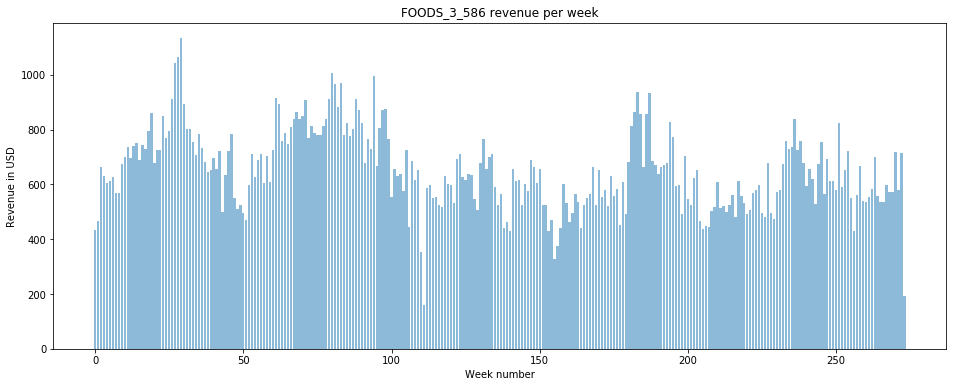

In [71]:
weeks=food.index
x = np.arange(len(weeks))

revenue=food['revenue']

plt.figure(figsize=(16,6))
plt.bar(x, revenue, align='center', alpha=0.5)
# plt.xticks(x, weeks)

plt.xlabel('Week number')
plt.ylabel('Revenue in USD')
plt.title('FOODS_3_586 revenue per week')
plt.show()

### 1.5.2. Item HOBBIES_1_354

In [75]:
hobbies= df[df['item_id']=='HOBBIES_1_354']
hobbies= hobbies.groupby('wm_yr_wk')[['revenue']].sum()

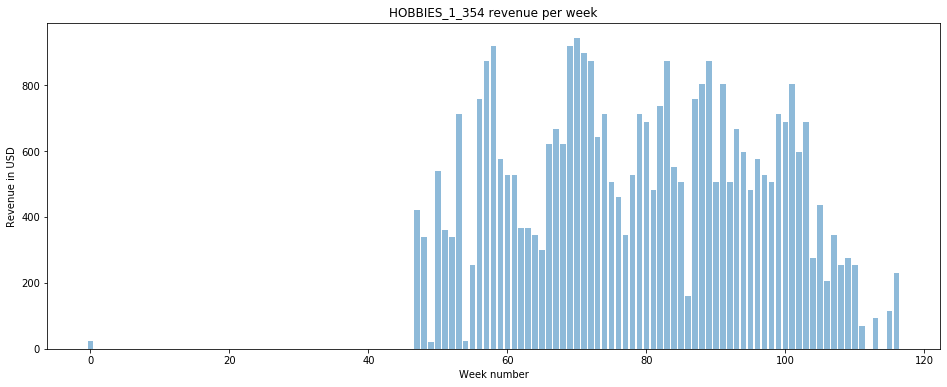

In [78]:
weeks=hobbies.index
x = np.arange(len(weeks))

revenue=hobbies['revenue']

plt.figure(figsize=(16,6))
plt.bar(x, revenue, align='center', alpha=0.5)
# plt.xticks(x, weeks)

plt.xlabel('Week number')
plt.ylabel('Revenue in USD')
plt.title('HOBBIES_1_354 revenue per week')
plt.show()

### 1.5.3 Item HOUSEHOLD_1_110

In [79]:
household= df[df['item_id']=='HOUSEHOLD_1_110']
household = household.groupby('wm_yr_wk')[['revenue']].sum()


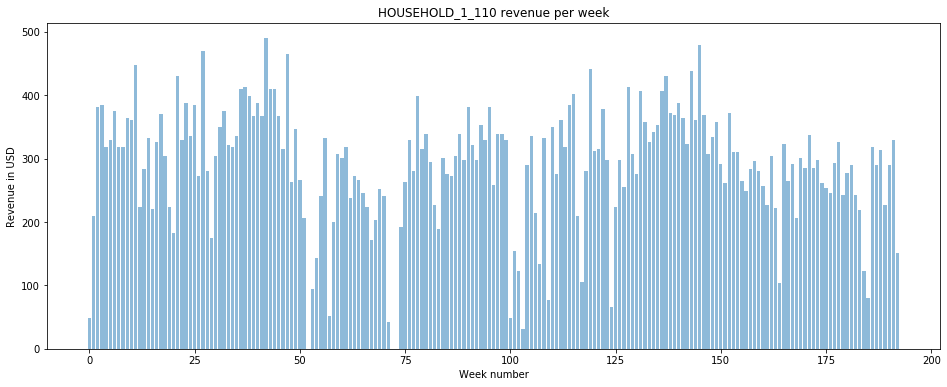

In [80]:
weeks=household.index
x = np.arange(len(weeks))

revenue=household['revenue']

plt.figure(figsize=(16,6))
plt.bar(x, revenue, align='center', alpha=0.5)
# plt.xticks(x, weeks)

plt.xlabel('Week number')
plt.ylabel('Revenue in USD')
plt.title('HOUSEHOLD_1_110 revenue per week')
plt.show()

In [81]:
del household
del hobbies
del food

In [82]:
del df['revenue']

## 2. Feature Engineering
### 2.1. Lag Features

In [162]:
# create df-s for three top items
df_3 = df[df['item_id']=='HOUSEHOLD_1_110']
df_2 = df[df['item_id']=='HOBBIES_1_354']
df_1 = df[df['item_id']=='FOODS_3_586']

### Define functions for the lag Features

In [84]:
def lag_features(df):
    '''
    Function returns data frame with lag features.
    
    '''
    #create data frame from data frame for lag features
    lag_df = df[['d','id', 'sales']]
    lag_group = lag_df.groupby('id')['sales']

    # create lag(shift) features: this represents sales 'shift' days ago
    shifts = [7,14,28,35,42]
    for i in shifts:
        lag_df[f'shift_{i}'] = lag_group.shift(i)
    
    
    # use shift min=7 with windows for rolling mean and std dev. calc  
    windows = [7,14,28,56,84,180]
    shifts = [7, 14] 
    for i in shifts:
        for j in windows:
            lag_df[f'rmean{j}_lag{i}'] = lag_group.shift(i).rolling(j).mean()
            lag_df[f'rstd{j}_lag{i}'] = lag_group.shift(i).rolling(j).std()
            
    return lag_df


def merge_lag_df(df,lag_df):
    
    '''
    Function returns merged df with lag features df.
    '''
    ### merge lag features with data frame
    
    lag_df.drop(columns = 'sales',axis=1,inplace=True)
    df = df.merge(lag_df, on=['id','d'], how='left')
    
    return df

def remove_nan(df):
    '''
    Function drops NaN, created by lag features.
    '''
    df = df.dropna()
    return df


### 2.2. Price Features

In [85]:
### lets define shift days = 7 as constant, equal to the prediction horizon.
### Note: actual prediction horizon, when scaled should be = 28 days.
SHIFT = 7

def price_features(df):
    
    '''
    Function returns data frame with price features(moving average = 14 days).
    '''
    
    price_group = df['sell_price'].shift(SHIFT).rolling(14)
    df['price_mean']= price_group.mean()
    df['price_max']= price_group.max()
    df['price_min']= price_group.min()
    df['price_std']= price_group.std()
    
    return df

In [87]:
# plt.plot(df_1['wm_yr_wk'],df_1['sell_price']);

### 3. Baseline Model

### Create baseline  prediction function

In [167]:
def predict_lgb(df):
    
    '''
    Function prints RMSE for train and test data.
    '''
    
    # Create X, Y
    # 'wday' duplicates 'weekday'- put in remove_col
    remove_col = ['store_id','state_id','sales','id', 'item_id', 'dept_id', 'cat_id', 'weekday'] 
    used_col = [c for c in df.columns.tolist() if c not in remove_col]
    y = df['sales']
    X = df[used_col]
    
    # Split train, test(last 7 days)
    X_train, X_test = X[:'2016-04-17'], X['2016-04-18':]
    y_train, y_test = y[:'2016-04-17'], y['2016-04-18':]
    
    
    train_data=lgb.Dataset(X_train,label=y_train)

    lgb_params = {"objective" : "poisson",
                  "metric" :"rmse",
                  "force_row_wise" : True,
                  "learning_rate" : 0.04,
                  #"sub_feature" : 0.8,
                  "sub_row" : 0.75,
                  "bagging_freq" : 1,
                  "lambda_l2" : 0.1,
                  #"nthread" : 4,
                  "metric": ["rmse"],
                  "verbosity": 1,
                  "num_iterations" : 100,
                  "num_leaves": 40,
                  "min_data_in_leaf": 11}


    start=datetime.now()
    estimator = lgb.train(lgb_params,train_data)
    stop=datetime.now()

    y_pred_train=estimator.predict(X_train)
    y_pred=estimator.predict(X_test)

    print('--------------------')
    print("RMSE_train:",(mean_squared_error(y_train.values, y_pred_train))**0.5)
    print("RMSE_test:",(mean_squared_error(y_test.values, y_pred))**0.5)
    print('--------------------')
    print()
    print('Naive benchmarks:')
    print('Predicted Test week average sales:',y_pred.mean())
    print('True Average Sales at:')
    print('Test week:',y_test.values.mean())
    print('Week before test:', y['2016-04-10':'2016-04-16'].values.mean())
    print('Last year at test week:', y['2015-04-20':'2015-04-26'].values.mean())
    print('--------------------')
    
#     print('Sales')

#     print('Predicted Test week:',np.round(y_pred.tolist()))
#     print('True Test week:',y_test.values.tolist())
#     print('Week before test:', y['2016-04-16':'2016-04-18'].values.tolist())
#     print('Last year @ test week:', y['['2015-04-20':'2015-04-26']'].values.tolist())

# lgb_params = {'boosting_type': 'gbdt',
#               'objective': 'tweedie',
#               'tweedie_variance_power': 1.1,
#               'metric': 'rmse',
#               'num_iterations' : 200,
#               'subsample': 0.7,
#               'subsample_freq': 1,
#               'learning_rate': 0.075,
#               'num_leaves': 40,
#               'min_data_in_leaf':1,
#               'feature_fraction': 0.5,
#               'max_bin': 100,
#               'n_estimators': 1400,
#               'boost_from_average': False,
#               'verbose': -1} 


    return None

### 3.1 Model for item_1

In [159]:
lag_df_1 = lag_features(df_1)
df_1 = merge_lag_df(df_1, lag_df_1)
df_1 = price_features(df_1)
df_1 = remove_nan(df_1)
df_1.set_index('date',inplace=True)

In [160]:
predict_lgb(df_1)

--------------------
RMSE_train: 10.07933122884226
RMSE_test: 16.227149648549762
--------------------

Naive benchmarks:
Predicted Test week average sales: 51.00629482502255
True Average Sales at:
Test week: 60.142857142857146
Week before test: 49.142857142857146
Last year at test week: 40.42857142857143
--------------------


### 3.2 Model for iitem_2

In [163]:
lag_df_2 = lag_features(df_2)
df_2 = merge_lag_df(df_2, lag_df_2)
df_2 = price_features(df_2)
df_2 = remove_nan(df_2)
df_2.set_index('date',inplace=True)

In [164]:
predict_lgb(df_2)

--------------------
RMSE_train: 1.288827505930173
RMSE_test: 3.7860544823257474
--------------------

Naive benchmarks:
Predicted Test week average sales: 0.4662634017377205
True Average Sales at:
Test week: 2.142857142857143
Week before test: 0.0
Last year at test week: 2.0
--------------------


### 3.3 Model for item_3

In [165]:
lag_df_3 = lag_features(df_3)
df_3 = merge_lag_df(df_3, lag_df_3)
df_3 = price_features(df_3)
df_3 = remove_nan(df_3)
df_3.set_index('date',inplace=True)

In [166]:
predict_lgb(df_3)

--------------------
RMSE_train: 3.5093504291078865
RMSE_test: 4.334986093319537
--------------------

Naive benchmarks:
Predicted Test week average sales: 10.503527194193225
True Average Sales at:
Test week: 13.428571428571429
Week before test: 11.142857142857142
Last year at test week: 14.428571428571429
--------------------


### Feature Importance for df_3

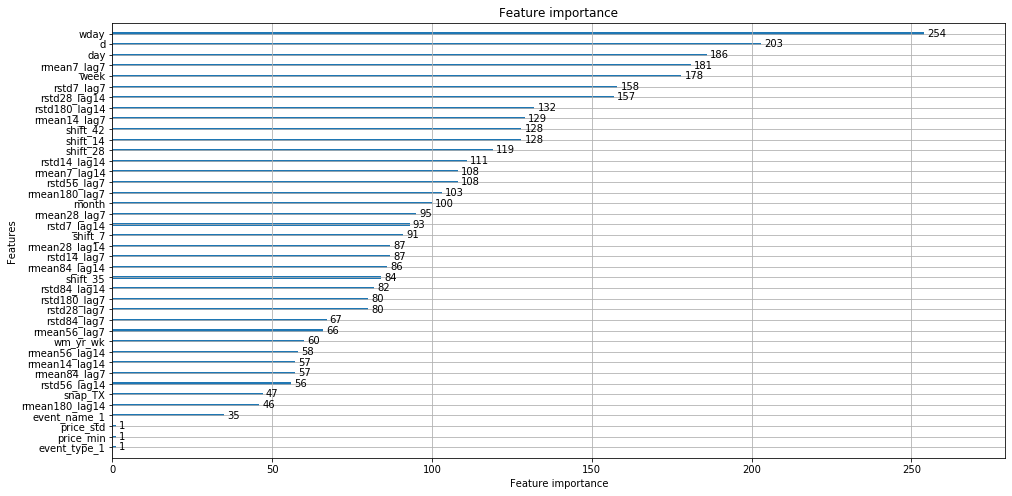

In [168]:
lgb.plot_importance(estimator, figsize=(16,8))

### Conclusions:
- Model needs improvement(currently overfits)
- Better features can help to improve results
- more testing required
- need to explore good validation strategy for time series

## Reference list

### 1.EDA.
https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda

https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration

https://www.kaggle.com/rohitsingh9990/m5-forecasting-eda-feature-engineering

### 2.a. Ideas/Concepts:
https://www.kaggle.com/kyakovlev/m5-lags-features

https://www.kaggle.com/kyakovlev/m5-simple-fe

https://www.kaggle.com/kyakovlev/m5-custom-features/comments

https://www.kaggle.com/kyakovlev/m5-three-shades-of-dark-darker-magic/data

https://www.kaggle.com/kyakovlev/m5-dark-magic/notebook

### 2.b. Ideas/Concepts:
https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/144067

https://www.kaggle.com/kyakovlev/m5-aux-models/kernels

https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/144067

https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/138881

https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/139461


### 3. Beginer notebooks:
https://www.kaggle.com/ragnar123/very-fst-model

https://www.kaggle.com/rohitsingh9990/m5-lgbm-fe


### 4. Modelling reference:
https://cran.r-project.org/web/packages/forecastML/vignettes/grouped_forecast.html

https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795

https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md

### 5. Python:
https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm

https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation

### 6. Data type and memory optimization:
https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html

### 7. Metrics:
https://www.kaggle.com/dhananjay3/wrmsse-evaluator-with-extra-features

https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

https://www.kaggle.com/girmdshinsei/for-japanese-beginner-with-wrmsse-in-lgbm

### 8. Notebooks:
https://www.kaggle.com/poedator/m5-under-0-50-optimized

https://www.kaggle.com/kneroma/m5-first-public-notebook-under-0-50

https://www.kaggle.com/kneroma/m5-forecast-v2-python

https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/141515

https://www.kaggle.com/qcw171717/top-down-distribution-method/comments#832295

https://www.kaggle.com/kernelgenerator/m5-accuracy-poisson-tweedie/notebook

https://www.kaggle.com/mayer79/m5-forecast-poisson-loss